In [42]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_TF_gc_separated_old as aformer
#import src.aformer_TF as aformer
from src.layers.layers_old import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_aformer_TF_genecentered_separated as training_utils


from scipy import stats



In [44]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-15')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2022-08-31 14:20:11.051367: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.127.213.10:8470}
2022-08-31 14:20:11.051421: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55198}
2022-08-31 14:20:11.068506: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.127.213.10:8470}
2022-08-31 14:20:11.068551: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55198}
2022-08-31 14:20:30.002675: E tensorflow/core/common_runtime/eager/context.cc:571] Unable to close remote context with ID 9767951867027809330 for worker: /job:worker/replica:0/task:0 due to failed to connect to all addresses
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1661955630.002356948","des

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-15


INFO:tensorflow:Initializing the TPU system: node-15


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [46]:
with strategy.scope():
    heads_dict = {}
    orgs = ["hg"]
    for k, org in enumerate(orgs):
        heads_dict[org] = int(k)

    model = aformer.aformer(kernel_transformation="relu_kernel_transformation",
                                dropout_rate=0.25,
                                input_length=65536,
                                num_heads=4,
                                numerical_stabilizer=0.0000001,
                                nb_random_features=128,
                                hidden_size=128,
                                d_model=128,
                                norm=True,
                                dim=32,
                                max_seq_length = 512,
                                rel_pos_bins=512,
                                widening = 2, ## ratio between first and second dense layer units in transformer block
                                conv_filter_size_1_seq=15,
                                conv_filter_size_2_seq=5,
                                conv_filter_size_1_atac=15,
                                conv_filter_size_2_atac=5,
                                positional_dropout_rate=0.1,
                                transformer_depth=2,
                                momentum=0.90,
                                channels_list=[48,48,56,56,64,64], 
                                kernel_regularizer=0.0000001,
                                bottleneck_units=32,
                            bottleneck_units_tf=32,
                                use_mask_pos=False,
                                use_rot_emb=True,
                                heads_dict=heads_dict)
    model.load_weights("gs://picard-testing-176520/65k_genecentered_blacklist0.50_atacnormalized/models/aformer_initial_tests_I65536_LR1e-06_KR0_WD1e-05_T2_H4_C7_AF.115_AF.25_SF.115_SF.25_D0.25_HS128/final/saved_model")


    def predict_on_batch(model, inputs):
        return model.predict_on_batch(inputs)

    @tf.function
    def contribution_input_grad(model, model_inputs,output_head='hg'):
        seq, atac, tf_acc=model_inputs

        with tf.GradientTape() as input_grad_tape:
            input_grad_tape.watch(seq)
            input_grad_tape.watch(atac)
            input_grad_tape.watch(tf_acc)
            inputs = seq,atac,tf_acc
            prediction = model.predict_on_batch(inputs)[0][output_head]


        input_grads = input_grad_tape.gradient(prediction,inputs)
        

        input_grads_seq = input_grads[0] 
        input_grads_atac = input_grads[1]
        input_grads_tf_acc = input_grads[2]
        
        
        seq_grads = tf.reduce_sum(input_grads_seq[0,:,1:] * seq[0,:,1:],
                                  axis=1)
        
        tss_grads = input_grads_seq[0,:,0]
        
        #atac_grads = input_grads_atac[0,:,] * atac[0,:,]
        
        #tf_acc_grads = input_grads[2][0,:]
        
        return seq_grads, tss_grads, input_grads_atac[0,:,],atac[0,:,],\
                input_grads_tf_acc, prediction


In [47]:
with strategy.scope():
    gcs_path = "gs://picard-testing-176520/65k_individual_genes/CD69/HG_JURKAT_U_U.tfr"
    unstim_data = training_utils.return_dataset_interpret(gcs_path,
                                                       strategy,
                                                         1,
                                                         65536,
                                                         "logTPM",
                                                         4,
                                                         10,
                                                         1637,
                                                         True)
    gcs_path = "gs://picard-testing-176520/65k_individual_genes/CD69/HG_JURKAT_U_PMA_IONO.tfr"
    stim_data = training_utils.return_dataset_interpret(gcs_path,
                                                       strategy,
                                                         1,
                                                         65536,
                                                         "logTPM",
                                                         4,
                                                         10,
                                                         1637,
                                                         True)
    
    unstim_input = next(unstim_data)
    inputs = unstim_input['inputs'].values[0],unstim_input['atac'].values[0], unstim_input['TF_acc'].values[0]
    unstim_scores = contribution_input_grad(model,inputs)
    
    
    stim_input = next(stim_data)
    inputs = stim_input['inputs'].values[0],stim_input['atac'].values[0], stim_input['TF_acc'].values[0]
    stim_scores = contribution_input_grad(model,inputs)
    

In [91]:
with strategy.scope():
    p_unstim_input = next(unstim_data)
    atac =p_unstim_input['atac'].values[0].numpy()
    ## now change the atac profile from bins 275 - 290
    atac[0,32768+2000:32768+5000,0]=0.0
    us_atac_perturb_tf = tf.convert_to_tensor(atac)
    
    inputs = p_unstim_input['inputs'].values[0],atac_perturb_tf, p_unstim_input['TF_acc'].values[0]
    
    p_unstim_scores = contribution_input_grad(model,inputs)
    
    
    p_stim_input = next(stim_data)
    atac =p_stim_input['atac'].values[0].numpy()
    ## now change the atac profile from bins 275 - 290
    atac[0,32768+2000:32768+5000,0]=0.0
    s_atac_perturb_tf = tf.convert_to_tensor(atac)
    
    inputs = p_stim_input['inputs'].values[0],atac_perturb_tf, p_stim_input['TF_acc'].values[0]
    
    p_stim_scores = contribution_input_grad(model,inputs)

In [23]:
def plot_track_seq(input_arr, start, stop, height=1.5):
    length=stop-start

    # Set y-limit, making neg y-values not show in plot
    #plt.ylim(start, stop)
    x_vals = np.linspace(start,stop,num=length)
    baseline = np.zeros_like(x_vals)
    # Filling between line y3 and line y4
    fig, ax = plt.subplots(figsize=(18, 1))
    ax.fill_between(x_vals, baseline, input_arr[start:stop],alpha=0.9)
    

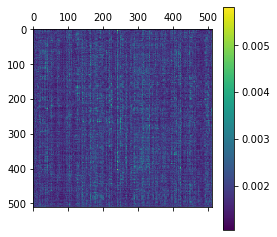

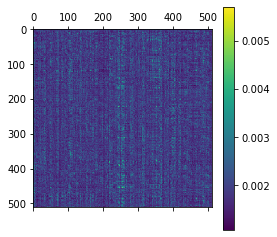

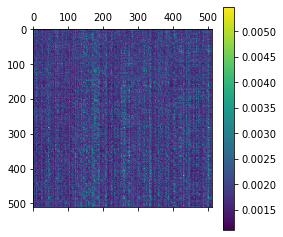

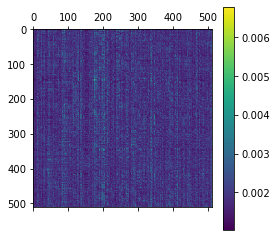

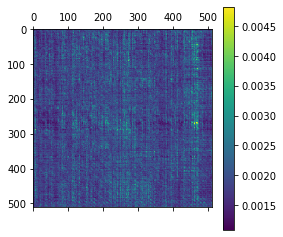

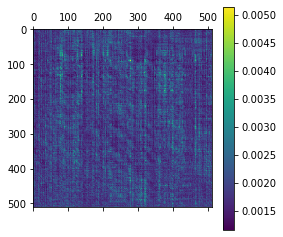

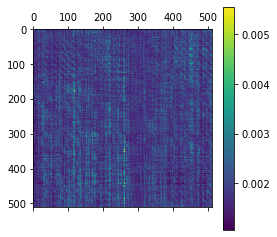

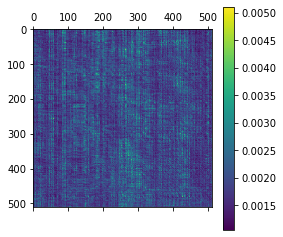

In [102]:
inputs = unstim_input['inputs'].values[0],unstim_input['atac'].values[0], unstim_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_0']
mat_unstim = []
promoter_att_unstim=[]
for i in range(0,4):
    temp = tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
    mat_unstim.append(temp)
    plt.matshow(temp)
    plt.colorbar()
    plt.show()
    temp_prom = tf.reduce_sum(temp[254:258,:],axis=0)
    promoter_att_unstim.append(temp_prom)


inputs = stim_input['inputs'].values[0],stim_input['atac'].values[0], stim_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_1']
mat_stim = []
promoter_att_stim=[]
for i in range(0,4):
    temp = tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
    mat_stim.append(temp)
    plt.matshow(temp)
    plt.colorbar()
    plt.show()
    temp_prom = tf.reduce_sum(temp[254:258,:],axis=0)
    promoter_att_stim.append(temp_prom)


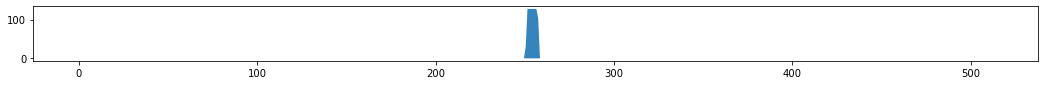

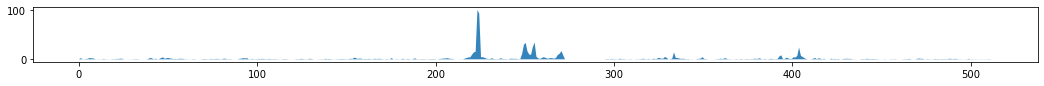

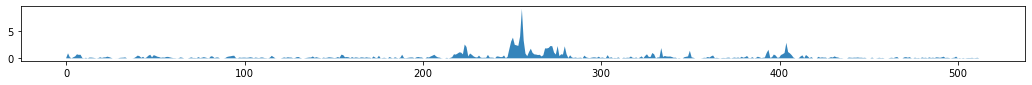

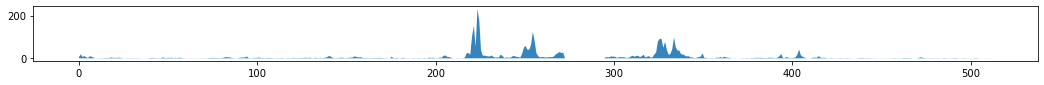

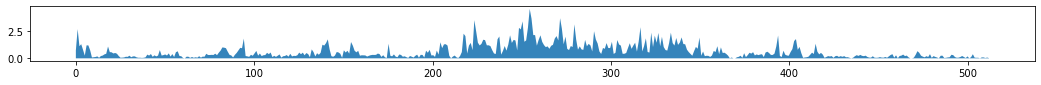

In [92]:
def bin_vector(input_arr, num_bins, output_res):
    return np.sum(input_arr.reshape(num_bins, output_res), axis=1)

plot_track_seq(bin_vector(unstim_input['tss_tokens'].values[0].numpy(),512,128),0,512)
plot_track_seq(bin_vector(us_atac_perturb_tf.numpy(),512,128),0,512)
plot_track_seq(bin_vector(np.abs(unstim_scores[2].numpy() * unstim_scores[3].numpy()),512,128),0,512)

plot_track_seq(bin_vector(s_atac_perturb_tf.numpy(),512,128),0,512)
plot_track_seq(bin_vector(np.abs(stim_scores[2].numpy() * stim_scores[3].numpy()),512,128),0,512)







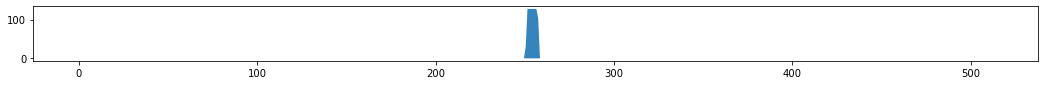

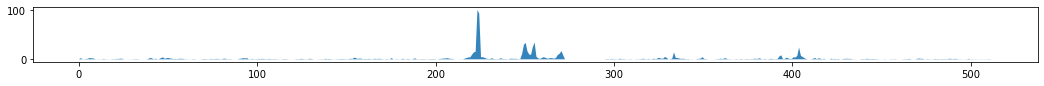

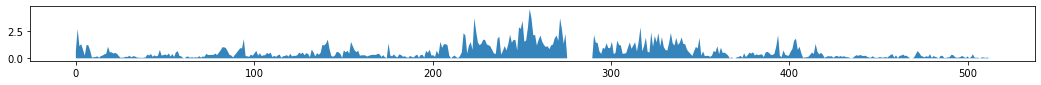

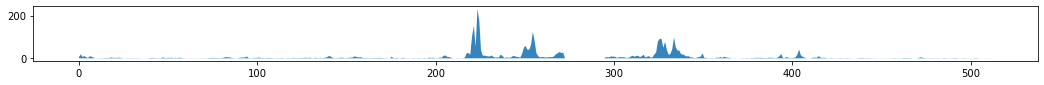

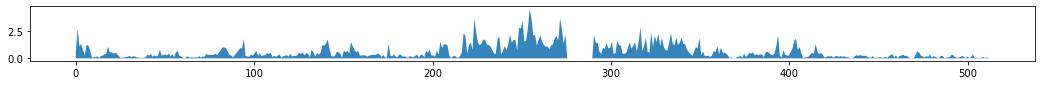

In [95]:
def bin_vector(input_arr, num_bins, output_res):
    return np.sum(input_arr.reshape(num_bins, output_res), axis=1)

plot_track_seq(bin_vector(p_unstim_input['tss_tokens'].values[0].numpy(),512,128),0,512)
plot_track_seq(bin_vector(us_atac_perturb_tf.numpy(),512,128),0,512)
plot_track_seq(bin_vector(np.abs(p_unstim_scores[2].numpy() * p_unstim_scores[3].numpy()),512,128),0,512)

plot_track_seq(bin_vector(s_atac_perturb_tf.numpy(),512,128),0,512)
plot_track_seq(bin_vector(np.abs(p_stim_scores[2].numpy() * p_stim_scores[3].numpy()),512,128),0,512)







In [96]:
p_stim_scores[-1].numpy()

array([[5.37962]], dtype=float32)

In [97]:
stim_scores[-1].numpy()

array([[5.535203]], dtype=float32)

In [98]:
p_unstim_scores[-1].numpy()

array([[5.37962]], dtype=float32)

In [99]:
unstim_scores[-1].numpy()

array([[2.959488]], dtype=float32)

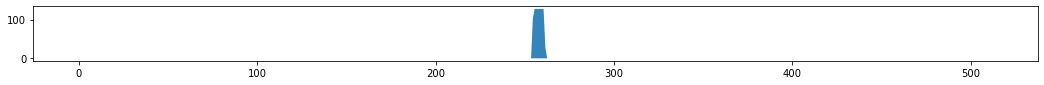

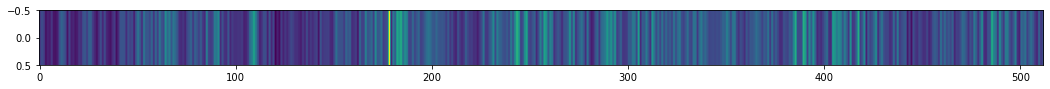

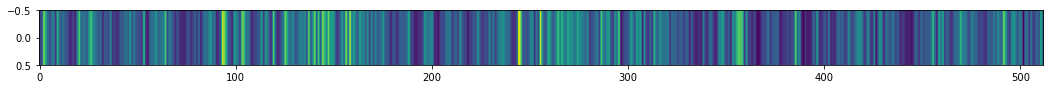

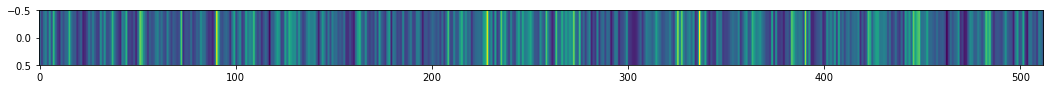

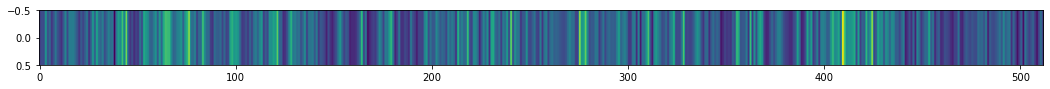

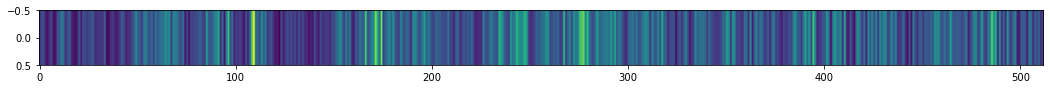

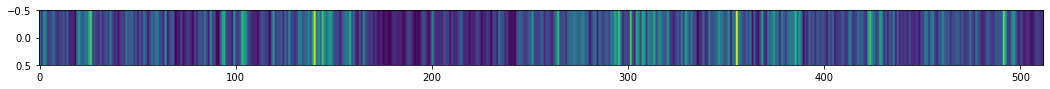

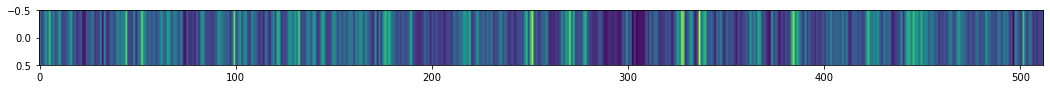

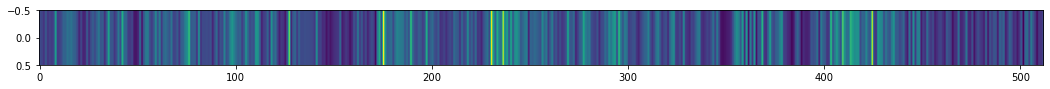

In [11]:
plot_track_seq(tf.reverse(bin_vector(unstim_input['tss_tokens'].values[0].numpy(),512,128),[0]),0,512)
fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_unstim[0],[0])[tf.newaxis], aspect = "auto", cmap="viridis")
fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_unstim[1],[0])[tf.newaxis], aspect = "auto", cmap="viridis")
fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_unstim[2],[0])[tf.newaxis], aspect = "auto", cmap="viridis")
fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_unstim[3],[0])[tf.newaxis], aspect = "auto", cmap="viridis")

fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_stim[0],[0])[tf.newaxis], aspect = "auto", cmap="viridis")
fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_stim[1],[0])[tf.newaxis], aspect = "auto", cmap="viridis")
fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_stim[2],[0])[tf.newaxis], aspect = "auto", cmap="viridis")
fig, ax = plt.subplots(figsize=(18, 1))
ax.imshow(tf.reverse(promoter_att_stim[3],[0])[tf.newaxis], aspect = "auto", cmap="viridis")

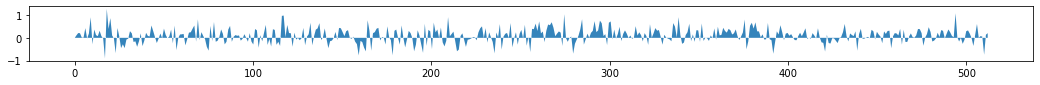

In [104]:
plot_track_seq(bin_vector(unstim_scores[0].numpy(),512,128), 0,512)

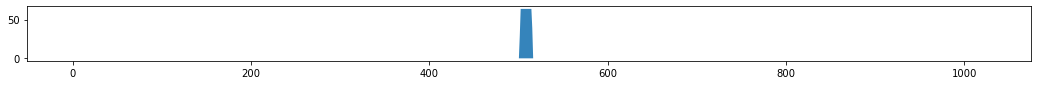

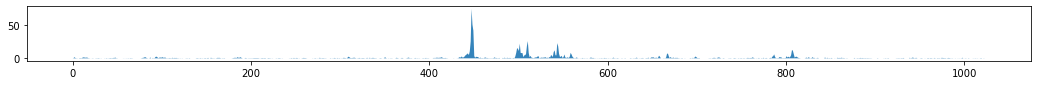

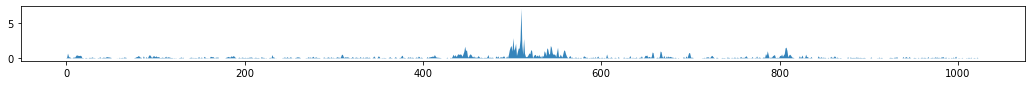

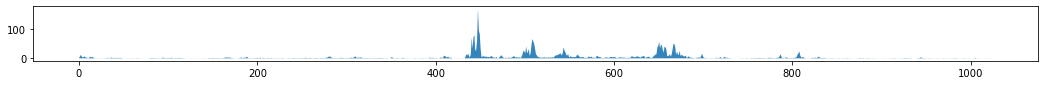

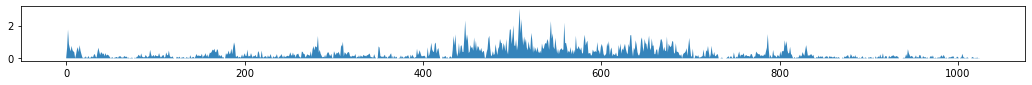

In [40]:
plot_track_seq((bin_vector(unstim_input['tss_tokens'].values[0].numpy(),1024,64)),0,1024)
plot_track_seq((bin_vector(unstim_input['atac'].values[0].numpy(),1024,64)),0,1024)
plot_track_seq((bin_vector(unstim_scores[2].numpy(),1024,64)),0,1024)

plot_track_seq((bin_vector(stim_input['atac'].values[0].numpy(),1024,64)),0,1024)
plot_track_seq((bin_vector(stim_scores[2].numpy(),1024,64)),0,1024)




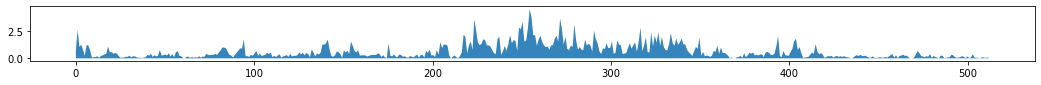

In [41]:
plot_track_seq(bin_vector(stim_scores[2].numpy(),512,128), 0,512)

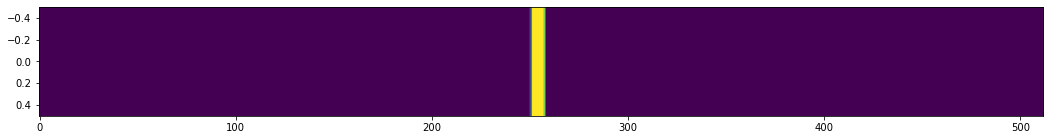

In [29]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(bin_vector(stim_input['tss_tokens'].values[0].numpy(),512,128)[tf.newaxis], aspect = "auto", cmap="viridis")


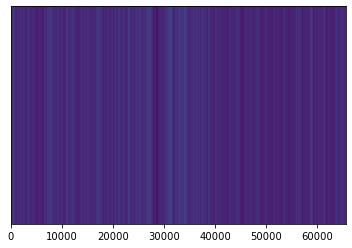

In [12]:
plt.imshow((tf.abs(unstim_scores[0][tf.newaxis])), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

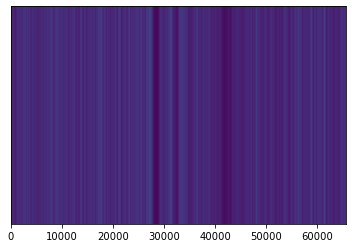

In [13]:
plt.imshow((tf.abs(stim_scores[0][tf.newaxis])), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

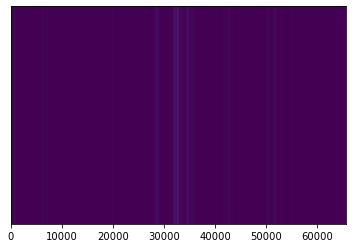

In [14]:
plt.imshow((tf.abs(unstim_scores[2][tf.newaxis])), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

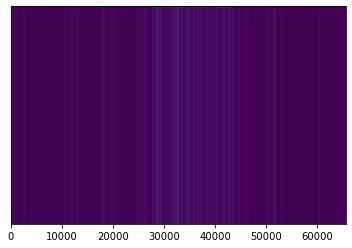

In [15]:
plt.imshow((tf.abs(stim_scores[2][tf.newaxis])), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

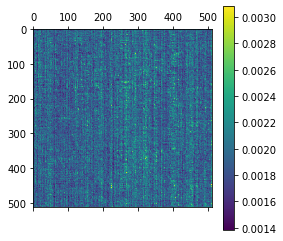

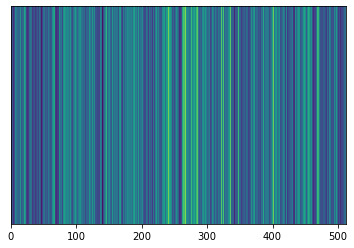

In [47]:
inputs = unstim_input['inputs'].values[0],unstim_input['atac'].values[0], unstim_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_0']
mat = tf.nn.softmax(tf.matmul(q_1[:,0,0,:],tf.transpose(k_1[:,0,0,:])) / tf.math.sqrt(128.0))
for i in range(1,4):
    mat += tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
mat = mat / 4.0
plt.matshow(mat)
plt.colorbar()
plt.show()

promoter_att = tf.reduce_sum(mat[252:260,:],axis=0)

plt.imshow((promoter_att[tf.newaxis]), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

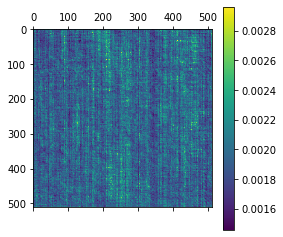

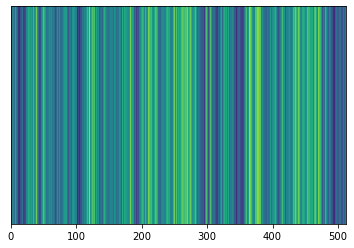

In [17]:
inputs = unstim_input['inputs'].values[0],unstim_input['atac'].values[0], unstim_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_1']
mat = tf.nn.softmax(tf.matmul(q_1[:,0,0,:],tf.transpose(k_1[:,0,0,:])) / tf.math.sqrt(128.0))
for i in range(1,4):
    mat += tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
mat = mat / 4.0
plt.matshow(mat)
plt.colorbar()
plt.show()

promoter_att = tf.reduce_sum(mat[252:260,:],axis=0)

plt.imshow((promoter_att[tf.newaxis]), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

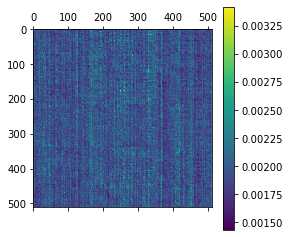

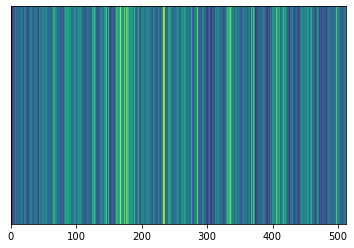

In [18]:
inputs = stim_input['inputs'].values[0],stim_input['atac'].values[0], stim_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_0']
mat = tf.nn.softmax(tf.matmul(q_1[:,0,0,:],tf.transpose(k_1[:,0,0,:])) / tf.math.sqrt(128.0))
for i in range(1,4):
    mat += tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
mat = mat / 4.0
plt.matshow(mat)
plt.colorbar()
plt.show()

promoter_att = tf.reduce_sum(mat[252:260,:],axis=0)

plt.imshow((promoter_att[tf.newaxis]), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

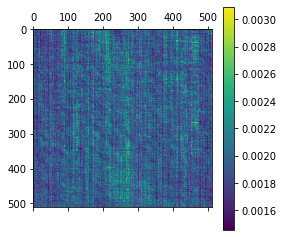

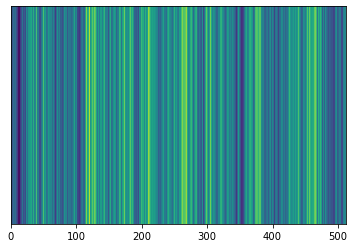

In [19]:
inputs = stim_input['inputs'].values[0],stim_input['atac'].values[0], stim_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_1']
mat = tf.nn.softmax(tf.matmul(q_1[:,0,0,:],tf.transpose(k_1[:,0,0,:])) / tf.math.sqrt(128.0))
for i in range(1,4):
    mat += tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
mat = mat / 4.0
plt.matshow(mat)
plt.colorbar()
plt.show()

promoter_att = tf.reduce_sum(mat[252:260,:],axis=0)

plt.imshow((promoter_att[tf.newaxis]), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

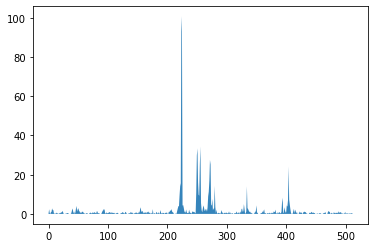

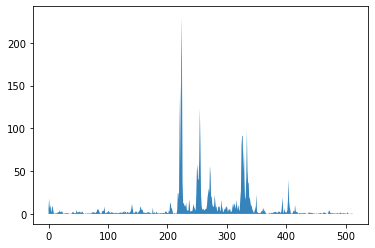

In [20]:
plot_track_seq(bin_vector(unstim_input['atac'].values[0].numpy(),512,128), 0,512)
plot_track_seq(bin_vector(stim_input['atac'].values[0].numpy(),512,128), 0,512)

In [69]:
stim_input_perturb = stim_input
atac_perturb =stim_input['atac'].values[0].numpy()

atac_perturb[0,32768+1500:32768+5000,0]=0.0
atac_perturb_tf = tf.convert_to_tensor(atac_perturb)
inputs = stim_input['inputs'].values[0],atac_perturb, stim_input['TF_acc'].values[0]
perturb_stim_scores = contribution_input_grad(model,inputs)

In [70]:
perturb_stim_scores[4]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[5.7843304]], dtype=float32)>

In [71]:
stim_scores[4]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[6.0336494]], dtype=float32)>

In [68]:
stim_input['atac'].values[0].numpy().shape#[32768+1500:32768+5000]

(1, 65536, 1)

In [67]:
stim_input_perturb = stim_input
atac_perturb =stim_input['atac'].values[0].numpy()

atac_perturb[0,32768+1500:32768+5000,0]=0.0
atac_perturb_tf = tf.convert_to_tensor(atac_perturb)

In [68]:
atac_perturb_tf

<tf.Tensor: shape=(1, 65536, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

In [70]:
stim_input['atac'].values[0].numpy().shape

(1, 65536, 1)